# Modelling #1 LogisticReg + HyperOpt

In [1]:
import sys
from pathlib import Path

PROJECT_ROOT = Path().resolve()
if PROJECT_ROOT.name == "notebooks":
    PROJECT_ROOT = PROJECT_ROOT.parent
elif PROJECT_ROOT.name.startswith("0"):
    PROJECT_ROOT = PROJECT_ROOT.parent.parent

if str(PROJECT_ROOT) not in sys.path:
    sys.path.append(str(PROJECT_ROOT))

%load_ext autoreload
%autoreload 2

In [2]:
# !pip install shap
# !pip install hyperopt
# !pip install loguru

In [3]:
import warnings
warnings.filterwarnings("ignore")

# Data Management
import json
import numpy as np
import pandas as pd

# Modelling
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedKFold
from sklearn.linear_model import LogisticRegression

# Opti
from hyperopt import hp, fmin, tpe, STATUS_OK, Trials

pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

from match_forecast.utils import *

2025-04-19 18:59:56.284 | INFO     | match_forecast.config:<module>:11 - PROJ_ROOT path is: /Users/maichoun/QRT-Challenge-2024


In [4]:
PROJ_ROOT = Path("QRT-Challenge-2024").resolve().parents[1]
DATA_DIR = PROJ_ROOT / "data"
RAW_DATA_DIR = DATA_DIR / "raw"
PROCESSED_DATA_DIR = DATA_DIR / "processed"

In [5]:
try:
    train_data = pd.read_csv(PROCESSED_DATA_DIR / "train_data.csv", index_col=0)
    train_scores = pd.read_csv(RAW_DATA_DIR / "Y_train.csv", index_col=0)
    print("Files loaded")
    
except FileNotFoundError as e:
    print(e)

Files loaded


In [6]:
train_data.shape

(12303, 275)

In [7]:
train_scores = train_scores.loc[train_data.index]
train_scores_1c = train_scores[['HOME_WINS', 'DRAW', 'AWAY_WINS']].idxmax(axis=1)
label_mapping = {'HOME_WINS': 0, 'DRAW': 1, 'AWAY_WINS': 2}
train_scores_1c = train_scores_1c.replace(label_mapping)

train_scores_1c.head(5)

ID
0    2
1    1
2    2
3    0
4    1
dtype: int64

In [8]:
X_train, X_test, y_train, y_test = train_test_split(train_data, train_scores_1c, train_size=0.8, random_state=42)

HyperOpt

In [9]:
space = {
    'C': hp.loguniform('C', -4, 4),             # Regularization strength (log scale: 1e-4 to 1e4)
    'l1_ratio': hp.uniform('l1_ratio', 0.0, 1.0), # ElasticNet mixing ratio
    'n_components': hp.quniform('n_components', 5, 100, 5)  # PCA components
}

In [10]:
n_splits = 10

def objective(params):
    n_components = int(params['n_components'])
    skf = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=42)
    accuracies = []
    
    for train_index, valid_index in skf.split(X_train, y_train):
        X_train_fold, X_valid_fold = X_train.iloc[train_index], X_train.iloc[valid_index]
        y_train_fold, y_valid_fold = y_train.iloc[train_index], y_train.iloc[valid_index]
        
        # Preprocess: Standardization and PCA for each fold independently.
        scaler = StandardScaler()
        X_train_fold_scaled = scaler.fit_transform(X_train_fold)
        X_valid_fold_scaled = scaler.transform(X_valid_fold)
        
        pca = PCA(n_components=n_components)
        X_train_fold_pca = pca.fit_transform(X_train_fold_scaled)
        X_valid_fold_pca = pca.transform(X_valid_fold_scaled)

        X_train_fold_pca_scaled = scaler.fit_transform(X_train_fold_pca)
        X_valid_fold_pca_scaled = scaler.transform(X_valid_fold_pca)

        # Define the logistic regression model with elastic net penalty.
        model = LogisticRegression(
            penalty='elasticnet',
            solver='saga',
            C=params['C'],
            l1_ratio=params['l1_ratio'],
            max_iter=2000,
            random_state=42
        )
        
        # Fit and predict using the PCA-transformed features
        model.fit(X_train_fold_pca_scaled, y_train_fold)
        y_pred = model.predict(X_valid_fold_pca_scaled)
        accuracy = accuracy_score(y_valid_fold, y_pred)
        accuracies.append(accuracy)

    mean_loss = 1 - np.mean(accuracies)
    return {'loss': mean_loss, 'status': STATUS_OK}

In [11]:
trials = Trials()
best = fmin(fn=objective,
            space=space,
            algo=tpe.suggest,
            max_evals=100,  
            trials=trials)

print("Best hyperparameters:", best)

  0%|          | 0/100 [00:00<?, ?trial/s, best loss=?]

100%|██████████| 100/100 [09:01<00:00,  5.41s/trial, best loss: 0.5002033552061409]
Best hyperparameters: {'C': 0.02193864835414044, 'l1_ratio': 0.9898893281337423, 'n_components': 50.0}


In [12]:
# Convert NumPy types to native Python types for JSON serialization
def convert_numpy(obj):
    if isinstance(obj, np.integer):
        return int(obj)  
    elif isinstance(obj, np.floating):
        return float(obj)  
    elif isinstance(obj, list):  
        return [convert_numpy(i) for i in obj]  
    elif isinstance(obj, dict):  
        return {key: convert_numpy(value) for key, value in obj.items()}  
    else:
        return obj

results_with_params = [
    {
        **convert_numpy(trial['result']),
        'params': {key: convert_numpy(value[0]) if value else None for key, value in trial['misc']['vals'].items()}  # Convert hyperparameters
    }
    for trial in trials.trials[:-1]
]

with open('logreg_model.json', 'w') as f:
    json.dump(results_with_params, f, indent=4)

print("Optimization results saved to 'logreg_model.json'")

Optimization results saved to 'logreg_model.json'


In [13]:
with open("logreg_model.json", "r") as f:
    results_with_params = json.load(f)

print("\nBest trial")
best_trial = min(results_with_params, key=lambda x: x["loss"])
print("Best hyperparameters:", best_trial["params"])
print("Best loss:", best_trial["loss"])


Best trial
Best hyperparameters: {'C': 0.02193864835414044, 'l1_ratio': 0.9898893281337423, 'n_components': 50.0}
Best loss: 0.5002033552061409


In [14]:
scaler = StandardScaler()
train_data_scaled = scaler.fit_transform(train_data)

pca_object = PCA(n_components=int(best_trial["params"]['n_components']))
pca = pca_object.fit_transform(train_data_scaled)
pca_scaled = scaler.fit_transform(pca)

n_components = pca_object.n_components_
train_data_reduced = pd.DataFrame(pca, columns=[f"PC{i+1}" for i in range(n_components)], index=train_data.index)

In [15]:
X_train, X_test, y_train, y_test = train_test_split(train_data_reduced, train_scores_1c, train_size=0.8, random_state=42)

In [16]:
final_model = LogisticRegression(
    penalty='elasticnet',
    solver='saga',
    C=best_trial["params"]['C'],
    l1_ratio=best_trial["params"]['l1_ratio'],
    max_iter=2000,
    random_state=42
)

final_model.fit(X_train, y_train)

LogisticRegression(C=0.02193864835414044, l1_ratio=0.9898893281337423,
                   max_iter=2000, penalty='elasticnet', random_state=42,
                   solver='saga')

In [17]:
y_pred_final = final_model.predict(X_test)

final_accuracy = accuracy_score(y_test, y_pred_final)
print(f"Accuracy (test) : {final_accuracy * 100:.2f}%")

Accuracy (test) : 50.06%


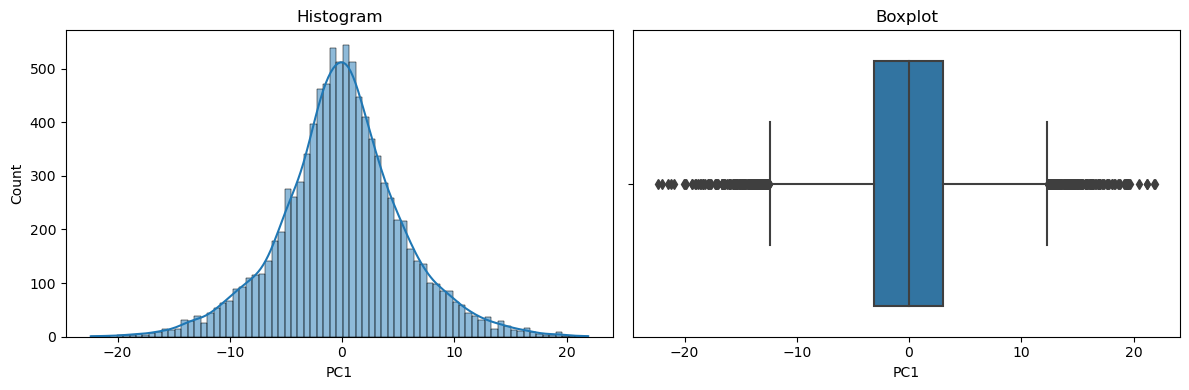

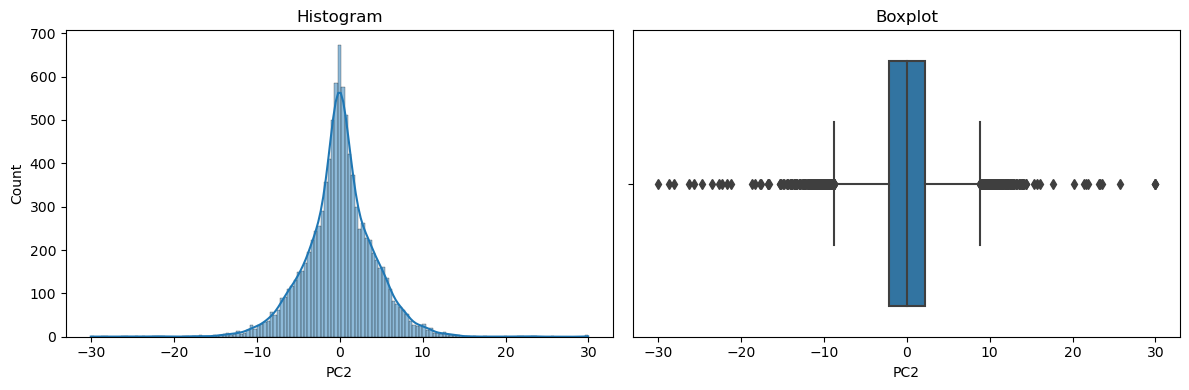

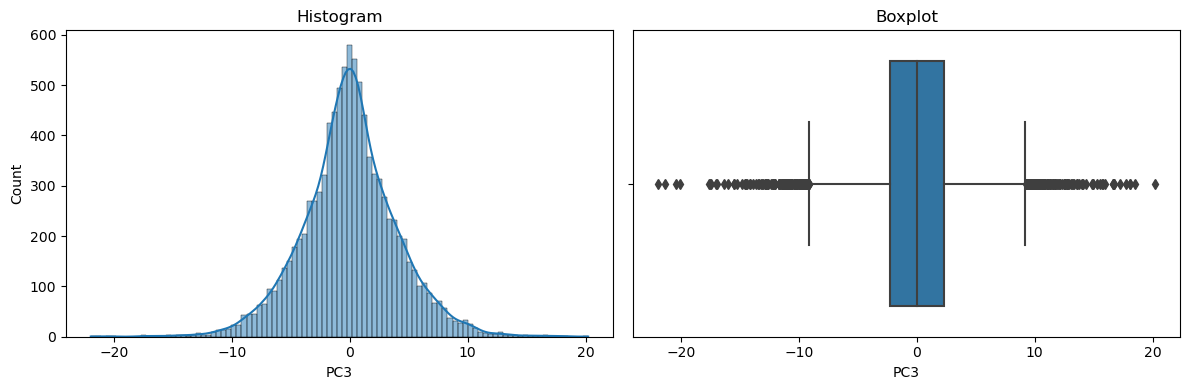

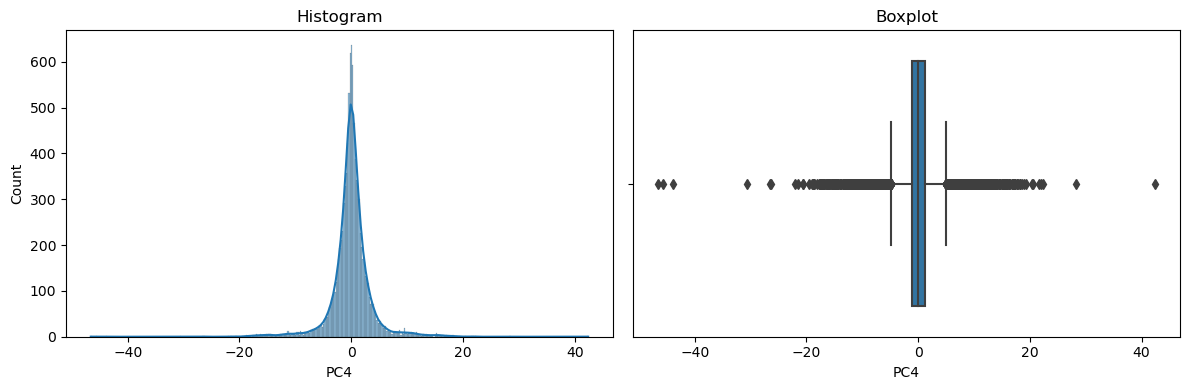

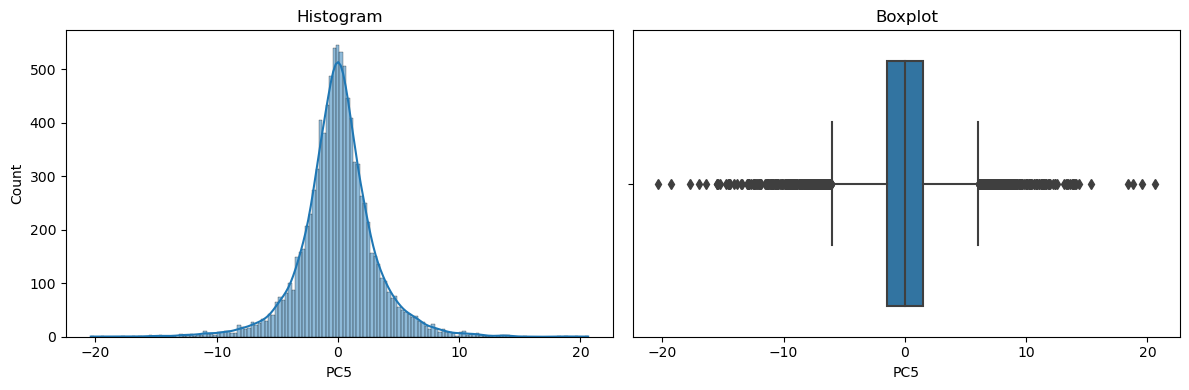

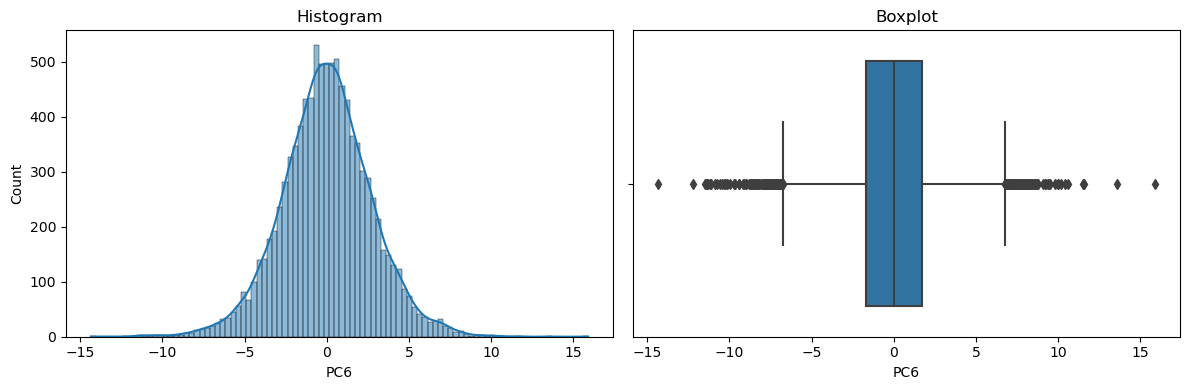

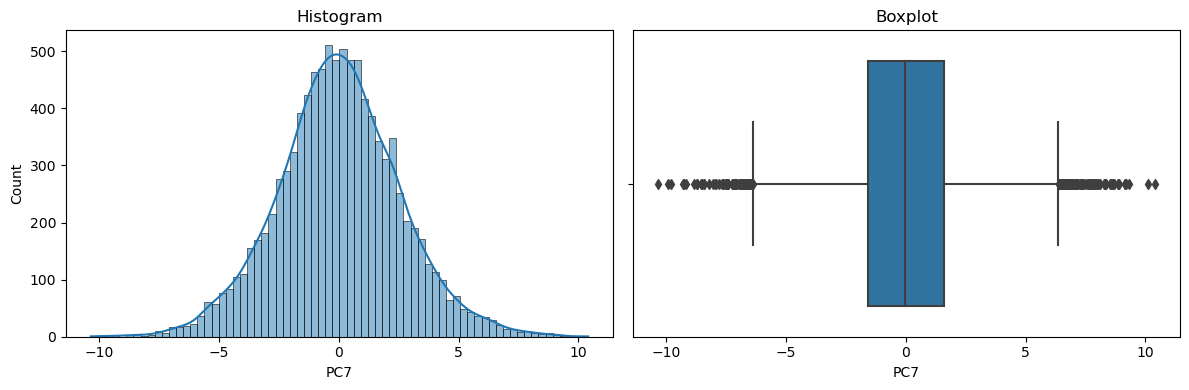

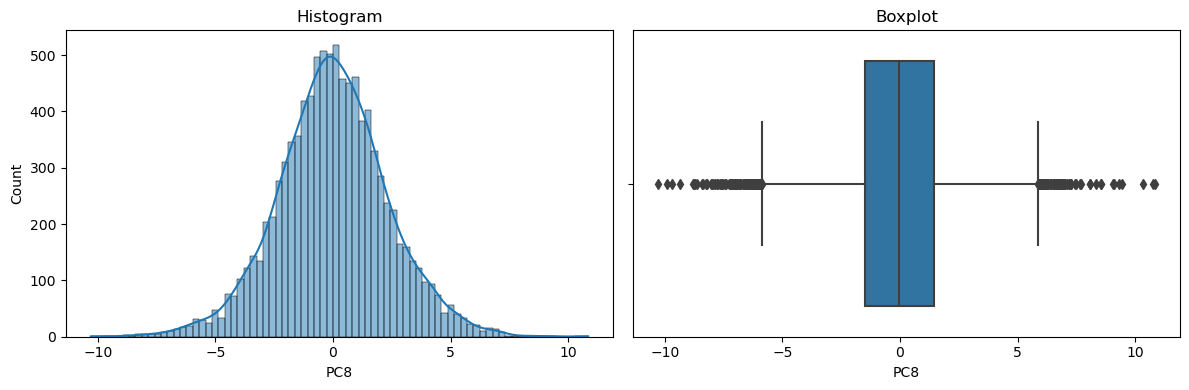

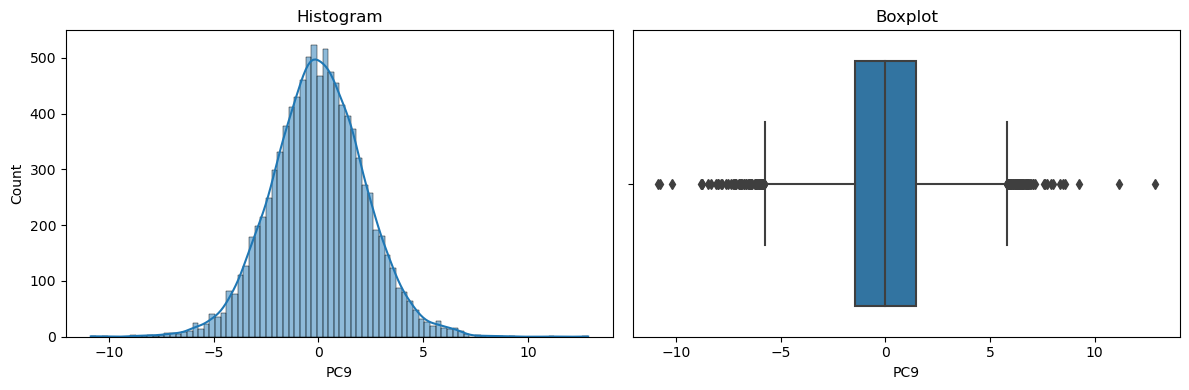

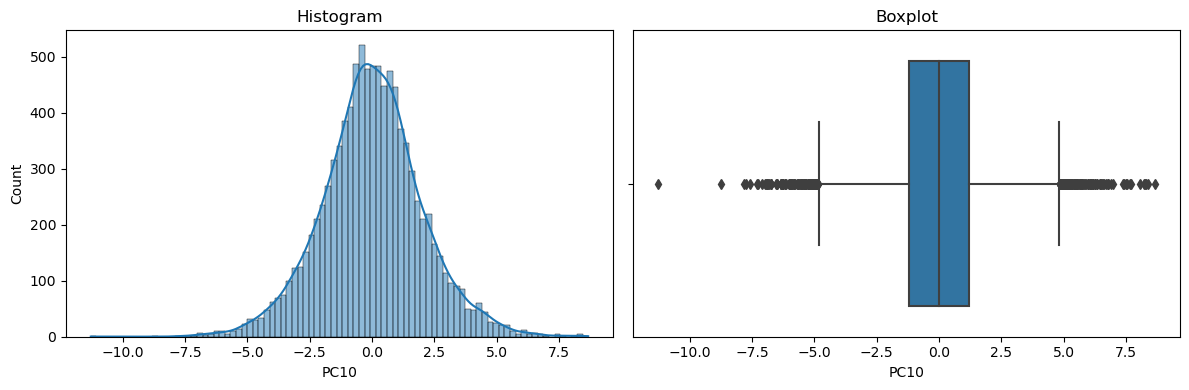

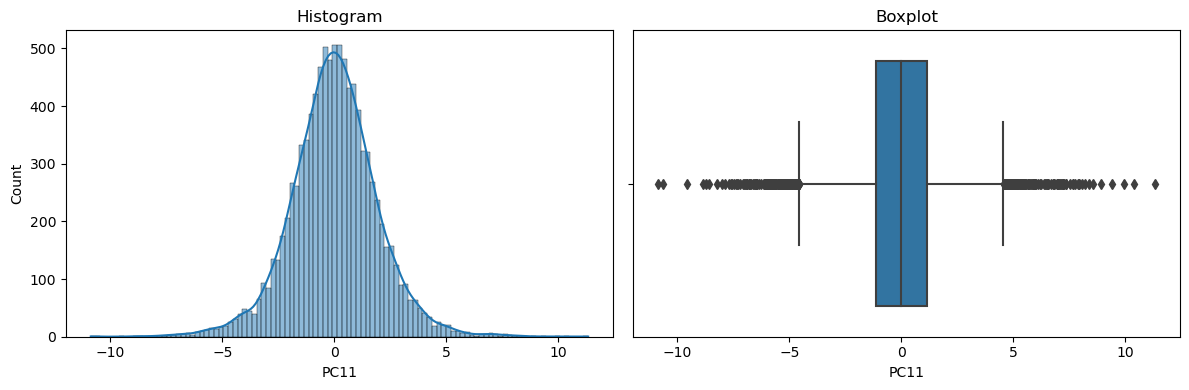

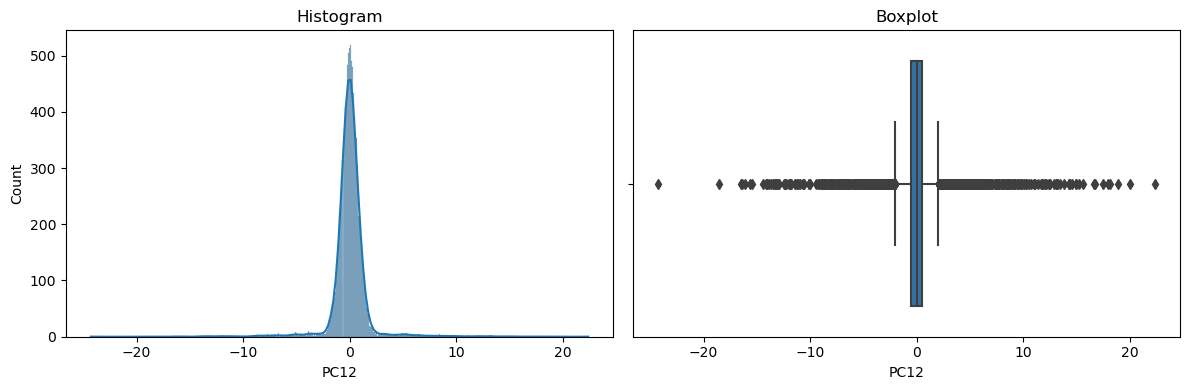

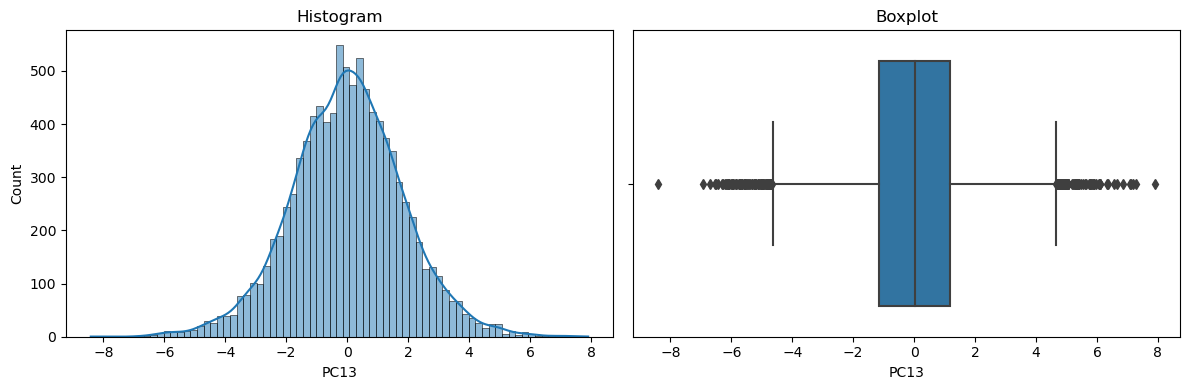

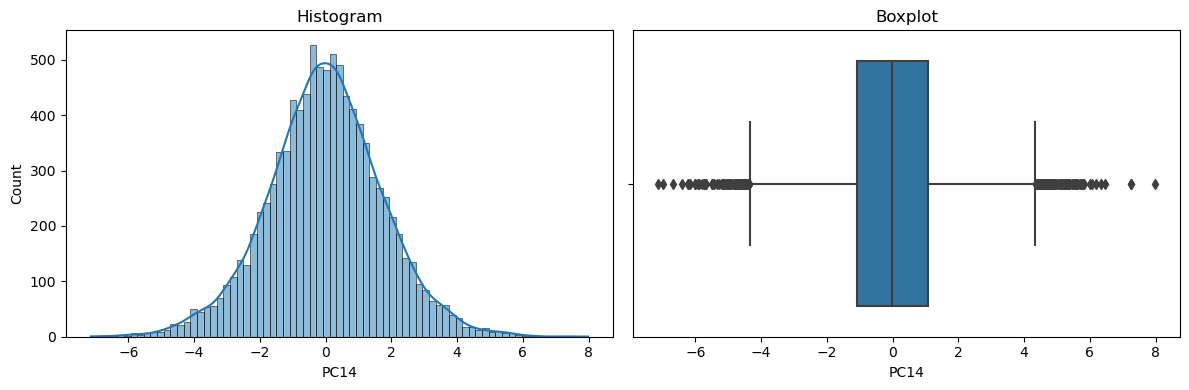

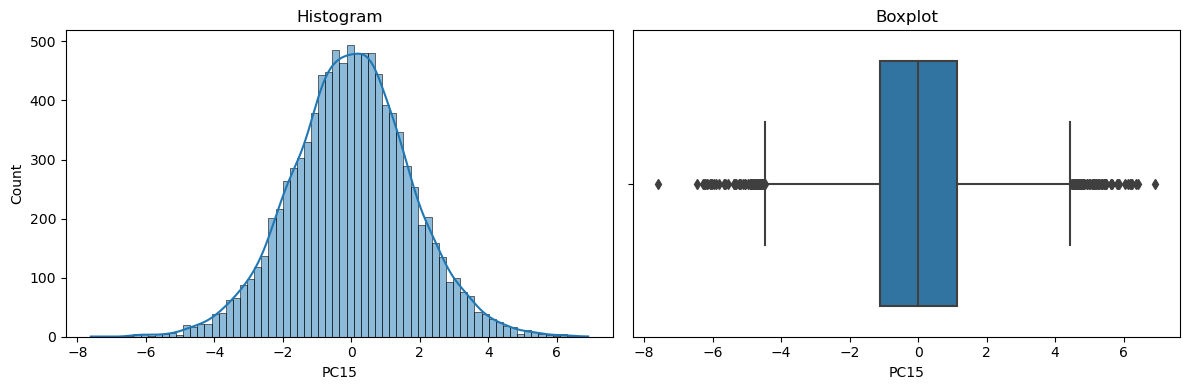

In [106]:
num_cols = X_train.select_dtypes(include=[np.number]).columns
cat_cols = X_train.select_dtypes(include=["object", "category"]).columns
plot_univariate_analysis(X_train, numeric_cols=num_cols, categorical_cols=cat_cols)